In [1]:
import convolution.kernel
import convolution.matrix
from noise import guassian_noise

from signals import rectangle
from domain import equispaced_points
from deconvolution.varpro import variable_projection


import matplotlib.pyplot as plt

from scipy.sparse import spdiags


import numpy as np

In [2]:
t = equispaced_points(512)

In [3]:
latent_signal = rectangle(t)

In [4]:
K_true = convolution.matrix.Operator(
    kernel=convolution.kernel.Gaussian(
        domain=t,
        standard_deviation=30
    ), 
    structure=convolution.matrix.toeplitz
)

In [5]:
convoluted_signal = K_true.image @ latent_signal

In [6]:
percentage = 0.01

In [7]:
noise = guassian_noise(percentage, convoluted_signal)

In [8]:
data = convoluted_signal + noise

In [9]:
k1 = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=60
)
k2 = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=10
)
K_guess = convolution.matrix.Operator(
    kernel=convolution.kernel.Mixture(
        weights=[0.5, 0.5], 
        kernels=[k1, k2]
    ), 
    structure=convolution.matrix.toeplitz
)

In [10]:
def L(x): 
    return np.identity(x.size)

def rjf_jacobian(K, x): 
    return np.transpose(np.array(K.partial_derivatives) @ x)

In [11]:
def total_variation(x): 
    BETA = 1e-16
    differential_operator = forward_difference_matrix(x)
    return np.diag((1/(((differential_operator*x)**2 + BETA**2)**(1/4)))) @ differential_operator


def forward_difference_matrix(data): 
    return spdiags([-np.ones_like(data), np.ones_like(data)], [0, 1], data.size, data.size)

In [12]:
regularization_parameter = 1e-1

In [13]:
K, x, iterations = variable_projection(
    data, 
    K_guess, 
    rjf_jacobian,
    regularization_parameter, 
    regularization_matrix=total_variation, 
    maximum_iterations=400
)

In [27]:
MSE_kernel_guess = np.linalg.norm(K_true.kernel.image - K_guess.kernel.image)**2 / data.size 
MSE_kernel_result = np.linalg.norm(K_true.kernel.image - K.kernel.image)**2 / data.size 
MSE_signal_data = np.linalg.norm(latent_signal - data)**2 / data.size 
MSE_signal_result = np.linalg.norm(latent_signal - x)**2 / data.size 

In [28]:
print(f'AFTER {iterations} iterations\n')
print(f'Regulization parameter: {regularization_parameter}\n')
print(f'Standard Deviation (TRUE): {K_true.kernel.variables}')
print(f'Standard Deviation (GUESS): {K_guess.kernel.variables}')
print(f'Standard Deviation (RESULT): {K.kernel.variables}\n')
print(f'Mean Squared Error of Kernels (TRUE & GUESS): {MSE_kernel_guess}')
print(f'Mean Squared Error of Kernels (TRUE & RESULT): {MSE_kernel_result}\n')
print(f'Mean Squared Error of Signal (TRUE & DATA): {MSE_signal_data}')
print(f'Mean Squared Error of Signal (TRUE & Result): {MSE_signal_result}')

AFTER 229 iterations

Regulization parameter: 0.1

Standard Deviation (TRUE): [30]
Standard Deviation (GUESS): (0.5, 0.5, 60, 10)
Standard Deviation (RESULT): (1.1868539472311077e-09, 0.999999998813146, 1406956.78853358, 29.236438277735708)

Mean Squared Error of Kernels (TRUE & GUESS): 4.5759469277145055e-06
Mean Squared Error of Kernels (TRUE & RESULT): 9.255086596885561e-09

Mean Squared Error of Signal (TRUE & DATA): 0.02731254000176472
Mean Squared Error of Signal (TRUE & Result): 0.006030223097932162


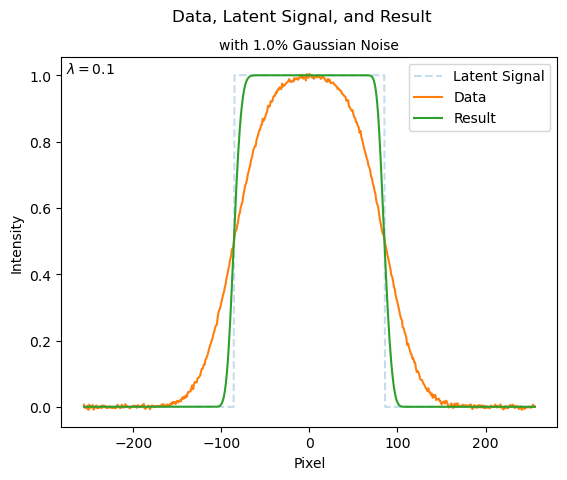

In [15]:
fig, ax = plt.subplots()
plt.suptitle('Data, Latent Signal, and Result')
plt.title(f'with {percentage * 100:}% Gaussian Noise', fontsize=10)
ax.plot(t, latent_signal, '--', label='Latent Signal', alpha=0.25)
ax.plot(t, data, label='Data')
ax.plot(t, x, label='Result')
ax.legend()
ax.text(.01, .99, r'$\lambda = $' + f'{regularization_parameter}', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Pixel')
plt.ylabel('Intensity');

In [16]:
w1, w2 = K.kernel.weights
k1, k2 = K.kernel.components

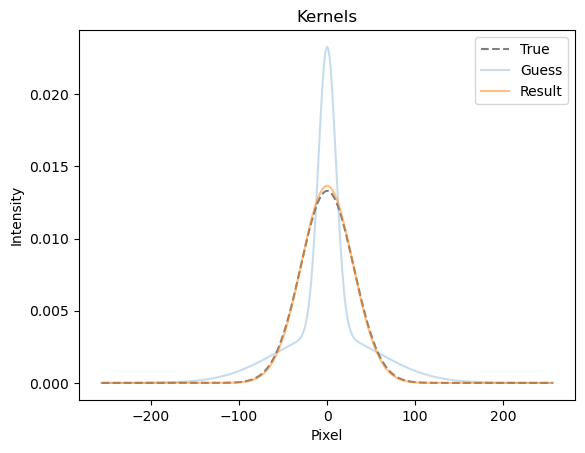

In [29]:
plt.title("Kernels")
plt.plot(t, K_true.kernel.image, 'k--', label='True', alpha=0.5)
plt.plot(t, K_guess.kernel.image, label="Guess", alpha=0.25)
plt.plot(t, K.kernel.image, label='Result', alpha=0.5)
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Intensity');